# Asteroids plot
2019.10.21
Revisiting problem from GTOC 4 - Asteroids Billiard
https://sophia.estec.esa.int/gtoc_portal/?page_id=23

Preliminary visualization of asteroids position

In [1]:
import numpy as np
import pandas as pd
import spiceypy as spice
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as animation
#import plotly.express as px


In [2]:
# load spice kernels
spice.furnsh('../spice/naif0012.tls')

In [3]:
# define function to create circle
def mycircle(x0,y0,r,points=100):
    """Function creates array of points to plot a 2D circle. Requires numpy package. 
    Args:
        x0 (float): x-coordinate of circle
        y0 (float): y-coordinate of circle
        r (float): radius
        points (int): number of points used to create circle
    Returns:
        (numpy array): points x 2 numpy array of coordinates of circle
    """
    # initialize array
    coord = np.zeros((points,2))
    # polar definition of circle
    theta = np.linspace(0, 2*np.pi, num=points)
    for i in range(points):
        coord[i,0] = r * np.sin(theta[i])
        coord[i,1] = r * np.cos(theta[i])
    
    return coord

In [4]:
# import ephemerides data from GTOC4 into pandas dataframe
df = pd.read_csv('../gtoc4_problem_data.txt', skiprows=2, delimiter= '\s+',header=None)
df.columns = ['Name','Epoch','a','e','i','LAN','omega','M0']

num,tmp = df.shape
print(df.shape)
df.tail(10)

(1436, 8)


,Name,Epoch,a,e,i,LAN,omega,M0
1426,'2008VC',54800.0,1.121759,0.172921,5.724475,218.482074,240.537647,339.437835
1427,'2008VF',54800.0,0.906074,0.325772,26.187102,234.456092,3.245131,204.193374
1428,'2008VG14',54800.0,2.867099,0.564880,10.181283,260.149763,112.941738,12.831283
1429,'2008VJ',54800.0,1.709902,0.467051,25.905756,227.553901,83.294990,51.255520
1430,'2008VU4',54800.0,2.371886,0.770038,11.974151,291.191885,23.168510,23.037338
1431,'2008WB',54800.0,1.371659,0.088384,43.893618,236.939816,163.400090,17.857428
1432,'2008WK',54800.0,1.420894,0.283407,6.366829,61.867245,28.835917,348.715701
1433,'2008WL',54800.0,2.740673,0.644534,6.725985,277.274962,109.877188,7.889516
1434,'2008WM',54800.0,1.073814,0.141095,12.313814,57.730478,84.910270,299.819922
1435,'6344P-L',54800.0,2.804108,0.667083,4.726812,183.611772,234.069655,79.379138


In [5]:
# reassign column names
df.columns =  ['Name','Epoch','a','e','i','LAN','omega','M0']
df.head(3)

,Name,Epoch,a,e,i,LAN,omega,M0
0,'1580',54800.0,2.196803,0.487683,52.090794,62.324795,159.539839,3.521687
1,'1620',54800.0,1.245551,0.335511,13.337693,337.266017,276.806539,136.950031
2,'1943',54800.0,1.430317,0.255816,8.704065,246.401915,338.253875,288.405238


### Preliminary visualization 
(validation of imported data)

In [6]:
# define gravitational parameters
MU    = 1.32712440018*10**11   # sun's gravitational parameter [km^3/s^2]
au2km = 1.49597870691*10**8    # astronomical unit [AU] to [km]
g0    = 9.80665                # gravitational acceleration [m/s^2]

# time to compute orbit position
#JD = df.at[0,'Epoch'] + 2400000.5  # convert Modified Julian Date to Julian Date
JD = 58731.65 + 2400000.5
strtime = str(JD) + ' JD'
et0 = spice.str2et(strtime)         # convert Julian Date to ephemeris seconds
print('State vector computed at: {}'.format(spice.et2utc(et0,'C',1)))

# compute initial state vector of asteroids
sv = np.zeros((6,num)) # initialize

for i in range(num):    
    rp = df.at[i,'a']*au2km * (1 - df.at[i,'e'])
    elts = [rp, df.at[i,'e'], np.rad2deg(df.at[i,'i']), np.rad2deg(df.at[i,'LAN']), np.rad2deg(df.at[i,'omega']), np.rad2deg(df.at[i,'M0']), et0, MU]
    tmp = spice.conics(elts,et0)
    # store position
    sv[0,i] = tmp[0]  # x-position
    sv[1,i] = tmp[1]  # y-position
    sv[2,i] = tmp[2]  # z-position
    # store velocity
    sv[3,i] = tmp[3]  # x-velocity
    sv[4,i] = tmp[4]  # y-velocity
    sv[5,i] = tmp[5]  # z-velocity
    
# also define colors, size
sizasterpod = 0.001 * np.ones(num)

# convert to tidy pandas dataframe
pos0_ast = pd.DataFrame({"x" : sv[0,:],
                       "y" : sv[1,:],
                       "z" : sv[2,:],
                       "vx" : sv[3,:],
                       "vy" : sv[4,:],
                       "vz" : sv[5,:],
                       "size" : sizasterpod})

pos0_ast.loc[1057]

State vector computed at: 2019 SEP 05 15:36:00.0


x      -5.194324e+06
y      -5.215249e+05
z       1.465447e+08
vx      1.695523e+01
vy     -2.760042e+01
vz     -4.050223e+00
size    1.000000e-03
Name: 1057, dtype: float64

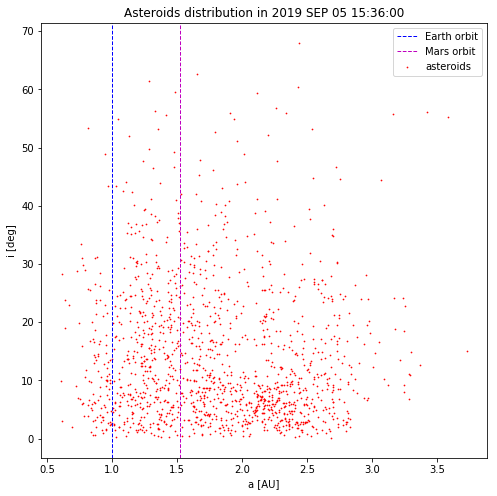

In [7]:
# plot statistical data of asteroids: inclination vs. semi-major axis
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()
x = np.zeros(num)
y = np.zeros(num)
for i in range(num):
    x[i] = df.at[i,'a']
    y[i] = df.at[i,'i']
    
plt.scatter(x, y, label='asteroids', c='r', s=0.5)
plt.axvline(x=1, label='Earth orbit',ls='--',lw=1,c='b')
plt.axvline(x=1.52, label='Mars orbit',ls='--',lw=1,c='m')

plt.title(f'Asteroids distribution in {spice.et2utc(et0,"c",0)}')
plt.xlabel('a [AU]')
plt.ylabel('i [deg]')
plt.legend()
plt.show()

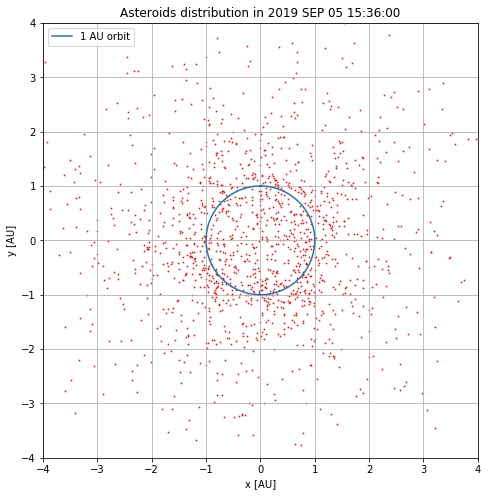

In [8]:
# plot statistical data of asteroids: orbit in x-y plane
fig = plt.figure(figsize=(8, 8))

x = np.zeros(num)
y = np.zeros(num)
for i in range(num):
    x[i] = pos0_ast.at[i,'x']
    y[i] = pos0_ast.at[i,'y']
    
    xx = pos0_ast.at[i,'x']/au2km
    yy = pos0_ast.at[i,'y']/au2km
    plt.scatter(xx, yy, c='r', s=0.5)

# create circle to represent Earth
circle_coord = mycircle(0,0,1)
plt.plot(circle_coord[:,0], circle_coord[:,1], label='1 AU orbit')

# formating plot
#plt.scatter(x, y, label='asteroids', c='r', s=0.5)
#plt.axvline(x=0, ls='--',lw=0.3, c='k')
#plt.axhline(y=0, ls='--',lw=0.3, c='k')
plt.grid()
plt.title(f'Asteroids distribution in {spice.et2utc(et0,"c",0)}')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.axis('scaled')
plt.legend()
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.show()



In [9]:
# Earth ephemeris
def Earth(param):
    """Function returns ephemeris value prompted, as defined by GTOC4 problem statement
    Args:
        param (str): orbital parameter to be fetched
            a: semi-major axis [AU]
            e: eccentricity
            i: inclination [deg]
            LAN: longitude of ascendig node [deg]
            omega: argument of periapsis [deg]
            M0: mean anomaly [deg]
            t: Epoch at which these elements are defined [MJD]
    Returns:
        (float): value of prompted parameter
    """
    if param == 'a':
        retval = 0.999988049532578
    elif param == 'e':
        retval = 1.671681163160 / np.power(10,2)
    elif param == 'i':
        retval = 0.8854353079654 / np.power(10,3)
    elif param == 'LAN':
        retval = 175.40647696473
    elif param == 'omega':
        retval = 287.61577546182
    elif param == 'M0':
        retval = 257.60683707535
    elif param == 't':
        retval = 54000
    else:
        print('function parameter is invalid')
        return None
    return retval


In [10]:
# compute Earth position
rp = Earth('a')*au2km * (1 - Earth('e'))
elts = [rp, Earth('e'), np.rad2deg(Earth('i')), np.rad2deg(Earth('LAN')), np.rad2deg(Earth('omega')), np.rad2deg(Earth('M0')), et0, MU]
etE = 58676.40 + 2400000.5
Earth0 = spice.conics(elts,etE)
Earth0

array([ 8.88099826e+04, -1.51900741e+08,  7.67777168e+06,  2.92911349e+01,
        3.87094214e-03,  1.42259745e-01])

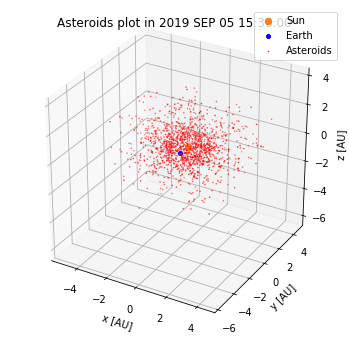

In [11]:
# plot 3D asteroid positions at one instance in time
#%matplotlib
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(0,0,0, c='tab:orange', label='Sun',s=40)
ax.scatter(Earth0[0]/au2km, Earth0[1]/au2km, Earth0[2]/au2km, c='b', label='Earth',s=16)
ax.scatter(sv[0,:]/au2km, sv[1,:]/au2km, sv[2,:]/au2km, c='r', s=0.3, label='Asteroids')

plt.title(f'Asteroids plot in {spice.et2utc(et0,"c",0)}')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.legend()
plt.show()


In [12]:
# 3D plotly orbit of asteroids
fig = px.scatter_3d(pos0_ast, x='x', y='y', z='z', size='size')
fig.show()

NameError: name 'px' is not defined

### Orbit Propagation over time range of interest

In [13]:
# Setup for orbit propagation
step = 1000
# start and end time (end time includes +10 years for operation)
utc = ['Jan 1, 2015','Dec 31, 2035']
etOne = spice.str2et(utc[0])  # convert to ephemeris seconds
etTwo = spice.str2et(utc[1])  # convert to ephemeris seconds
print("ET One: {}, ET Two: {}".format(etOne, etTwo))

# get times between start and end
etRange = [x*(etTwo-etOne)/step + etOne for x in range(step)]
    

ET One: 473342467.18391585, ET Two: 1135944069.183874


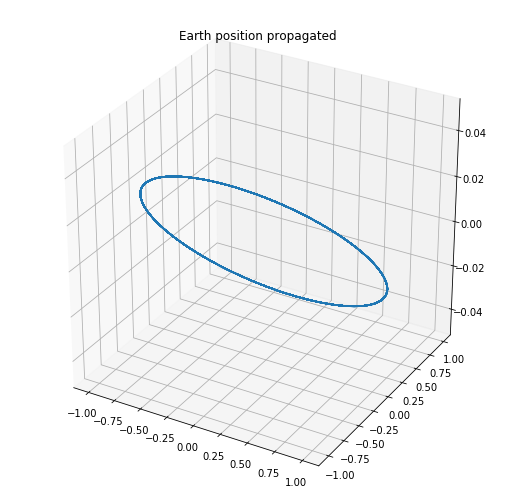

In [14]:
# Earth orbit propagation
# initialize state-vector matrix
sv_prop_Earth = np.zeros((6,step))

for i in range(step):
    elts = [rp, Earth('e'), np.rad2deg(Earth('i')), np.rad2deg(Earth('LAN')), np.rad2deg(Earth('omega')), np.rad2deg(Earth('M0')), et0, MU]
    tmp = spice.conics(elts,etRange[i]) # propagate state vector of Earth
    # store position
    sv_prop_Earth[0,i] = tmp[0]  # x-position
    sv_prop_Earth[1,i] = tmp[1]  # y-position
    sv_prop_Earth[2,i] = tmp[2]  # z-position
    # store velocity
    sv_prop_Earth[3,i] = tmp[3]  # x-velocity
    sv_prop_Earth[4,i] = tmp[4]  # y-velocity
    sv_prop_Earth[5,i] = tmp[5]  # z-velocity

# plot propagated orbit
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection = '3d')
ax.plot(sv_prop_Earth[0]/au2km, sv_prop_Earth[1]/au2km, sv_prop_Earth[2]/au2km)
plt.title('Earth position propagated')
plt.show()


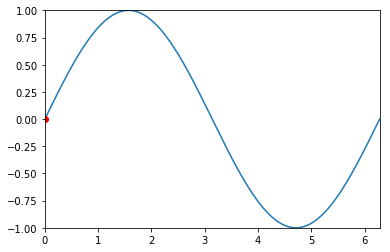

In [15]:
TWOPI = 2*np.pi

fig, ax = plt.subplots()

t = np.arange(0.0, TWOPI, 0.001)
s = np.sin(t)
l = plt.plot(t, s)

ax = plt.axis([0,TWOPI,-1,1])

redDot, = plt.plot([0], [np.sin(0)], 'ro')

def animate(i):
    redDot.set_data(i, np.sin(i))
    return redDot,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(0.0, TWOPI, 0.1),interval=10, blit=True, repeat=True)

plt.show()


In [ ]:
# Tisserand's parameter
# https://en.wikipedia.org/wiki/Tisserand%27s_parameter